## Setting up:

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
import massbalancemachine as mbm
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from cmcrameri import cm
from oggm import utils

from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.config_NOR import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.NorwayConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon

# For bars and lines:
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_1 = colors[0]
color_2 = '#c51b7d'

### Load stakes, fill missing start dates, split into winter and annual and transform to WGMS format

###### Dataset acquired from https://doi.org/10.58059/sjse-6w92

In [3]:
df_stakes = pd.read_csv(cfg.dataPath + path_PMB_WGMS_raw + 'glaciological_point_mass_balance_Norway.csv')

df_stakes = df_stakes.rename(columns={'rgiid': 'RGIId'})

# Add data modification column to keep track of mannual changes
df_stakes['DATA_MODIFICATION'] = ''

# FROM_DATE is missing in some glaciers despite having pmb measurements, fill with start of hydr. year
df_stakes_filled = fill_missing_dates(df_stakes)

# Split into winter and annual measurements
df_stakes_split = split_stake_measurements(df_stakes_filled)

# Transform to WGMS format
df_stakes_split = df_stakes_split.rename(columns={
    'lat': 'POINT_LAT', 
    'lon': 'POINT_LON',
    'altitude': 'POINT_ELEVATION',
    'breid': 'GLACIER',
})
# Only keep relevant columns in df
df_stakes_split = df_stakes_split[[
                                                 'POINT_LAT', 
                                                 'POINT_LON', 
                                                 'POINT_ELEVATION', 
                                                 'FROM_DATE', 
                                                 'TO_DATE', 
                                                 'POINT_BALANCE', 
                                                 'PERIOD', 
                                                 'RGIId', 
                                                 'YEAR',
                                                 'GLACIER',
                                                 'DATA_MODIFICATION',
                                                 'approx_loc',
                                                 'approx_altitude']]

display(df_stakes_split)



Filling 226 missing previous year dates...


,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,approx_loc,approx_altitude
0,70.12589,21.77702,471,25.09.2012,07.11.2013,-4.92,annual,RGI60-08.01258,2013,54,,N,N
1,70.12578,21.77630,439,07.11.2013,24.09.2014,-2.67,annual,RGI60-08.01258,2014,54,,N,N
2,70.12573,21.77590,444,24.09.2014,23.09.2015,-3.41,annual,RGI60-08.01258,2015,54,,N,N
3,70.12573,21.77590,444,23.09.2015,22.09.2016,-3.59,annual,RGI60-08.01258,2016,54,,N,N
4,70.12554,21.77352,468,22.09.2016,29.09.2017,-2.46,annual,RGI60-08.01258,2017,54,,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656,59.93803,6.34733,1078,01.10.2012,03.05.2012,1.50,winter,RGI60-08.02969,2012,3141,,N,N
7657,59.93789,6.34729,1078,12.10.2012,29.05.2013,1.14,winter,RGI60-08.02969,2013,3141,,N,N
7658,59.93815,6.34702,1079,14.10.2014,22.04.2015,1.19,winter,RGI60-08.02969,2015,3141,,N,N
7659,59.93803,6.34724,1078,14.10.2015,28.04.2016,1.72,winter,RGI60-08.02969,2016,3141,,N,N


###### convert datetime to yyyymmdd

In [4]:
df_stakes_split['FROM_DATE'] = pd.to_datetime(df_stakes_split['FROM_DATE'], format='%d.%m.%Y').dt.strftime('%Y%m%d')
df_stakes_split['TO_DATE'] = pd.to_datetime(df_stakes_split['TO_DATE'], format='%d.%m.%Y').dt.strftime('%Y%m%d')

###### Get glacier names from RGIId

In [5]:
# initialize OGGM glacier directories
gdirs, rgidf = initialize_oggm_glacier_directories(
    working_dir = cfg.dataPath + path_OGGM,
    rgi_region="08",
    rgi_version="6",
    base_url=
    "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/",
    log_level='WARNING',
    task_list=None,
)

# Create a dictionary mapping from RGIId to glacier name
rgi_to_name_dict = dict(zip(rgidf.RGIId, rgidf.Name))
df_stakes_split['GLACIER'] = df_stakes_split['RGIId'].map(rgi_to_name_dict)

# RGI60-08.02966 has no glacier name in the RGI map so directly give it name Blåbreen
df_stakes_split.loc[df_stakes_split['GLACIER'].isna(), 'GLACIER'] = 'Blabreen'

2025-06-11 07:13:11: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-06-11 07:13:11: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-06-11 07:13:11: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-06-11 07:13:11: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-06-11 07:13:11: oggm.cfg: Multiprocessing switched ON after user settings.
2025-06-11 07:13:11: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2025-06-11 07:13:12: oggm.workflow: init_glacier_directories from prepro level 3 on 3417 glaciers.
2025-06-11 07:13:12: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3417 glaciers
2025-06-11 07:13:25: oggm.workflow: Execute entity tasks [gridded_attributes] on 3417 glaciers


###### Create unique POINT_ID

In [6]:
display(df_stakes_split.head(2))

# Create new POINT_ID column
df_stakes_split['POINT_ID'] = (
    df_stakes_split['GLACIER'] + '_' + 
    df_stakes_split['YEAR'].astype(str) + '_' + 
    df_stakes_split['PERIOD'].astype(str) + '_' +
    df_stakes_split['POINT_LAT'].astype(str) + '_' +
    df_stakes_split['POINT_LON'].astype(str) + '_' +
    df_stakes_split['approx_loc'].astype(str) + '_' +
    df_stakes_split['approx_altitude'].astype(str) + '_' +
    df_stakes_split.index.astype(str)
)

# Drop columns that are not needed anymore
df_stakes_split = df_stakes_split.drop(columns=['approx_loc', 'approx_altitude'])

display(df_stakes_split.head(2))

,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,approx_loc,approx_altitude
0,70.12589,21.77702,471,20120925,20131107,-4.92,annual,RGI60-08.01258,2013,Langfjordjoekulen,,N,N
1,70.12578,21.77630,439,20131107,20140924,-2.67,annual,RGI60-08.01258,2014,Langfjordjoekulen,,N,N


,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,POINT_ID
0,70.12589,21.77702,471,20120925,20131107,-4.92,annual,RGI60-08.01258,2013,Langfjordjoekulen,,Langfjordjoekulen_2013_annual_70.12589_21.7770...
1,70.12578,21.77630,439,20131107,20140924,-2.67,annual,RGI60-08.01258,2014,Langfjordjoekulen,,Langfjordjoekulen_2014_annual_70.12578_21.7763...


#### Fix problematic date ranges

In [7]:
annual_inconsistent, winter_inconsistent = check_period_consistency(df_stakes_split)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
if len(annual_inconsistent) > 0:
    print("\nInconsistent annual periods:")
    display(annual_inconsistent[['GLACIER', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'POINT_ID']])

if len(winter_inconsistent) > 0:
    print("\nInconsistent winter periods:")
    display(winter_inconsistent[['GLACIER', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'POINT_ID']])

Annual periods: 40 out of 3910 (1.0%) are inconsistent
Winter periods: 39 out of 3751 (1.0%) are inconsistent

Inconsistent annual periods:


,GLACIER,FROM_DATE,TO_DATE,MONTH_DIFF,PERIOD,YEAR,RGIId,POINT_ID
83,Langfjordjoekulen,20130107,20140924,20,annual,2014,RGI60-08.01258,Langfjordjoekulen_2014_annual_70.12859_21.74082_N_N_83
107,Langfjordjoekulen,20191007,20100923,-109,annual,2010,RGI60-08.01258,Langfjordjoekulen_2010_annual_70.12532_21.71837_N_N_107
137,Langfjordjoekulen,20191007,20100923,-109,annual,2010,RGI60-08.01258,Langfjordjoekulen_2010_annual_70.12525_21.71792_N_N_137
357,Storsteinsfjellbreen,19681021,19680830,-2,annual,1968,RGI60-08.02458,Storsteinsfjellbreen_1968_annual_68.21998_17.92082_N_N_357
867,Svartisheibreen,19880912,19881018,1,annual,1988,RGI60-08.01598,Svartisheibreen_1988_annual_66.55518_13.76956_N_N_867
883,Svartisheibreen,19930929,19940515,8,annual,1994,RGI60-08.01598,Svartisheibreen_1994_annual_66.55012_13.72724_N_N_883
884,Svartisheibreen,19930929,19940515,8,annual,1994,RGI60-08.01598,Svartisheibreen_1994_annual_66.54826_13.73128_N_N_884
1094,Aalfotbreen,19650925,19651022,1,annual,1965,RGI60-08.02666,Aalfotbreen_1965_annual_61.75473_5.6671_N_N_1094
1126,Aalfotbreen,19861122,19870108,2,annual,1987,RGI60-08.02666,Aalfotbreen_1987_annual_61.75323_5.6695_N_N_1126
1213,Aalfotbreen,19950104,19960923,20,annual,1996,RGI60-08.02666,Aalfotbreen_1996_annual_61.75704_5.65747_Y_N_1213



Inconsistent winter periods:


,GLACIER,FROM_DATE,TO_DATE,MONTH_DIFF,PERIOD,YEAR,RGIId,POINT_ID
3989,Langfjordjoekulen,20130107,20140509,16,winter,2014,RGI60-08.01258,Langfjordjoekulen_2014_winter_70.12859_21.74082_N_N_3989
4010,Langfjordjoekulen,20191007,20100519,-113,winter,2010,RGI60-08.01258,Langfjordjoekulen_2010_winter_70.12532_21.71837_N_N_4010
4019,Langfjordjoekulen,20190927,20190526,-4,winter,2019,RGI60-08.01258,Langfjordjoekulen_2019_winter_70.12528_21.71827_N_N_4019
4038,Langfjordjoekulen,20191007,20100519,-113,winter,2010,RGI60-08.01258,Langfjordjoekulen_2010_winter_70.12525_21.71792_N_N_4038
4155,Blaaisen,19661020,19660520,-5,winter,1966,RGI60-08.02436,Blaaisen_1966_winter_68.33479_17.85005_N_N_4155
4251,Storsteinsfjellbreen,19681021,19680512,-5,winter,1968,RGI60-08.02458,Storsteinsfjellbreen_1968_winter_68.21998_17.92082_N_N_4251
4739,Svartisheibreen,19880912,19880525,-4,winter,1988,RGI60-08.01598,Svartisheibreen_1988_winter_66.55518_13.76956_N_N_4739
4946,Aalfotbreen,19650925,19650528,-4,winter,1965,RGI60-08.02666,Aalfotbreen_1965_winter_61.75473_5.6671_N_N_4946
5064,Aalfotbreen,19950104,19960501,16,winter,1996,RGI60-08.02666,Aalfotbreen_1996_winter_61.75704_5.65747_Y_N_5064
5379,Aalfotbreen,19661118,19670929,10,winter,1967,RGI60-08.02666,Aalfotbreen_1967_winter_61.74294_5.6365_N_N_5379


###### First fix is to switch all the months that have been wrongfully recorded as 01 instead of 10

In [8]:
# This function corrects the dates where 01 (Jan) has been entered as the month instead of 10 (Oct)
df_stakes_split_fixed1 = fix_january_to_october_dates(df_stakes_split, annual_inconsistent, winter_inconsistent)

annual_inconsistent, winter_inconsistent = check_period_consistency(df_stakes_split_fixed1)

if len(annual_inconsistent) > 0:
    print("\nInconsistent annual periods:")
    display(annual_inconsistent[['GLACIER', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'POINT_ID']])

if len(winter_inconsistent) > 0:
    print("\nInconsistent winter periods:")
    display(winter_inconsistent[['GLACIER', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'POINT_ID']])

Made 21 fixes (01 → 10) across 79 inconsistent records
Annual periods: 28 out of 3910 (0.7%) are inconsistent
Winter periods: 30 out of 3751 (0.8%) are inconsistent

Inconsistent annual periods:


,GLACIER,FROM_DATE,TO_DATE,MONTH_DIFF,PERIOD,YEAR,RGIId,POINT_ID
107,Langfjordjoekulen,20191007,20100923,-109,annual,2010,RGI60-08.01258,Langfjordjoekulen_2010_annual_70.12532_21.71837_N_N_107
137,Langfjordjoekulen,20191007,20100923,-109,annual,2010,RGI60-08.01258,Langfjordjoekulen_2010_annual_70.12525_21.71792_N_N_137
357,Storsteinsfjellbreen,19681021,19680830,-2,annual,1968,RGI60-08.02458,Storsteinsfjellbreen_1968_annual_68.21998_17.92082_N_N_357
867,Svartisheibreen,19880912,19881018,1,annual,1988,RGI60-08.01598,Svartisheibreen_1988_annual_66.55518_13.76956_N_N_867
883,Svartisheibreen,19930929,19940515,8,annual,1994,RGI60-08.01598,Svartisheibreen_1994_annual_66.55012_13.72724_N_N_883
884,Svartisheibreen,19930929,19940515,8,annual,1994,RGI60-08.01598,Svartisheibreen_1994_annual_66.54826_13.73128_N_N_884
1094,Aalfotbreen,19650925,19651022,1,annual,1965,RGI60-08.02666,Aalfotbreen_1965_annual_61.75473_5.6671_N_N_1094
1386,Aalfotbreen,19731120,19750920,22,annual,1974,RGI60-08.02666,Aalfotbreen_1974_annual_61.74236_5.64623_N_N_1386
1493,Aalfotbreen,19701011,19701124,1,annual,1971,RGI60-08.02666,Aalfotbreen_1971_annual_61.75213_5.63165_N_N_1493
1859,Nigardsbreen,20110929,20111013,1,annual,2011,RGI60-08.01126,Nigardsbreen_2011_annual_61.69385_7.16134_N_N_1859



Inconsistent winter periods:


,GLACIER,FROM_DATE,TO_DATE,MONTH_DIFF,PERIOD,YEAR,RGIId,POINT_ID
4010,Langfjordjoekulen,20191007,20100519,-113,winter,2010,RGI60-08.01258,Langfjordjoekulen_2010_winter_70.12532_21.71837_N_N_4010
4019,Langfjordjoekulen,20190927,20190526,-4,winter,2019,RGI60-08.01258,Langfjordjoekulen_2019_winter_70.12528_21.71827_N_N_4019
4038,Langfjordjoekulen,20191007,20100519,-113,winter,2010,RGI60-08.01258,Langfjordjoekulen_2010_winter_70.12525_21.71792_N_N_4038
4155,Blaaisen,19661020,19660520,-5,winter,1966,RGI60-08.02436,Blaaisen_1966_winter_68.33479_17.85005_N_N_4155
4251,Storsteinsfjellbreen,19681021,19680512,-5,winter,1968,RGI60-08.02458,Storsteinsfjellbreen_1968_winter_68.21998_17.92082_N_N_4251
4739,Svartisheibreen,19880912,19880525,-4,winter,1988,RGI60-08.01598,Svartisheibreen_1988_winter_66.55518_13.76956_N_N_4739
4946,Aalfotbreen,19650925,19650528,-4,winter,1965,RGI60-08.02666,Aalfotbreen_1965_winter_61.75473_5.6671_N_N_4946
5379,Aalfotbreen,19661118,19670929,10,winter,1967,RGI60-08.02666,Aalfotbreen_1967_winter_61.74294_5.6365_N_N_5379
5625,Hansebreen,20111013,20121117,13,winter,2012,RGI60-08.02650,Hansebreen_2012_winter_61.74307_5.66278_N_N_5625
5673,Nigardsbreen,20110929,20110503,-4,winter,2011,RGI60-08.01126,Nigardsbreen_2011_winter_61.69385_7.16134_N_N_5673


###### Second fix is some by hand and the rest are wrong years

In [9]:
## Fix outliers that don't have common explanation by hand
# May instead of september
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Svartisheibreen_1994_annual_66.55012_13.72724_N_N_883', 'TO_DATE'] = '19940915'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Svartisheibreen_1994_annual_66.54826_13.73128_N_N_884', 'TO_DATE'] = '19940915'
# TO_DATE annual wrong year
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Aalfotbreen_1974_annual_61.74236_5.64623_N_N_1386', 'TO_DATE'] = '19740920'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Aalfotbreen_1971_annual_61.75213_5.63165_N_N_1493', 'TO_DATE'] = '19711124'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Graafjellsbrea_2009_annual_60.06923_6.38925_N_N_3545', 'TO_DATE'] = '20091013'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Bondhusbrea_1981_annual_60.03108_6.31014_N_N_3738', 'TO_DATE'] = '19810827'
# TO_DATE winter wrong year
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Langfjordjoekulen_2019_winter_70.12528_21.71827_N_N_4019', 'TO_DATE'] = '20200526'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Langfjordjoekulen_2019_winter_70.12528_21.71827_N_N_4019', 'YEAR'] = '2020'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Langfjordjoekulen_2019_winter_70.12528_21.71827_N_N_4019', 'POINT_ID'] = 'Langfjordjoekulen_2020_winter_70.12528_21.71827_N_N_4019'

df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Blaaisen_1966_winter_68.33479_17.85005_N_N_4155', 'TO_DATE'] = '19670520'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Blaaisen_1966_winter_68.33479_17.85005_N_N_4155', 'YEAR'] = '1967'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Blaaisen_1966_winter_68.33479_17.85005_N_N_4155', 'POINT_ID'] = 'Blaaisen_1967_winter_68.33479_17.85005_N_N_4155'

df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Nigardsbreen_1963_winter_61.71461_7.11601_N_N_5802', 'TO_DATE'] = '19640507'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Nigardsbreen_1963_winter_61.71461_7.11601_N_N_5802', 'YEAR'] = '1964'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Nigardsbreen_1963_winter_61.71461_7.11601_N_N_5802', 'POINT_ID'] = 'Nigardsbreen_1964_winter_61.71461_7.11601_N_N_5802'

df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Vesledalsbreen_1967_winter_61.84804_7.25335_N_N_6694', 'TO_DATE'] = '19680418'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Vesledalsbreen_1967_winter_61.84804_7.25335_N_N_6694', 'YEAR'] = '1968'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Vesledalsbreen_1967_winter_61.84804_7.25335_N_N_6694', 'POINT_ID'] = 'Vesledalsbreen_1968_winter_61.84804_7.25335_N_N_6694'

df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Hellstugubreen_2010_winter_61.57329_8.44438_N_N_6935', 'TO_DATE'] = '20110505'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Hellstugubreen_2010_winter_61.57329_8.44438_N_N_6935', 'YEAR'] = '2011'
df_stakes_split_fixed1.loc[df_stakes_split_fixed1['POINT_ID']=='Hellstugubreen_2010_winter_61.57329_8.44438_N_N_6935', 'POINT_ID'] = 'Hellstugubreen_2011_winter_61.57329_8.44438_N_N_6935'

# These stakes have nonsensical periods, remove them out of df and index list
stakes_to_remove = ['Austdalsbreen_2017_annual_61.81113_7.36766_Y_N_3038',
                    'Austdalsbreen_2017_annual_61.80888_7.38239_Y_N_3065',
                    'Aalfotbreen_1967_winter_61.74294_5.6365_N_N_5379',
                    'Hansebreen_2012_winter_61.74307_5.66278_N_N_5625',
                    'Austdalsbreen_2017_winter_61.81113_7.36766_Y_N_6792',
                    'Austdalsbreen_2017_winter_61.80888_7.38239_Y_N_6819']
df_stakes_split_fixed1 = df_stakes_split_fixed1[~df_stakes_split_fixed1['POINT_ID'].isin(stakes_to_remove)]

annual_inconsistent, winter_inconsistent = check_period_consistency(df_stakes_split_fixed1)

if len(annual_inconsistent) > 0:
    print("\nInconsistent annual periods:")
    display(annual_inconsistent[['GLACIER', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'POINT_ID']])

if len(winter_inconsistent) > 0:
    print("\nInconsistent winter periods:")
    display(winter_inconsistent[['GLACIER', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'POINT_ID']])
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')


Annual periods: 20 out of 3908 (0.5%) are inconsistent
Winter periods: 21 out of 3747 (0.6%) are inconsistent

Inconsistent annual periods:


,GLACIER,FROM_DATE,TO_DATE,MONTH_DIFF,PERIOD,YEAR,RGIId,POINT_ID
107,Langfjordjoekulen,20191007,20100923,-109,annual,2010,RGI60-08.01258,Langfjordjoekulen_2010_annual_70.12532_21.71837_N_N_107
137,Langfjordjoekulen,20191007,20100923,-109,annual,2010,RGI60-08.01258,Langfjordjoekulen_2010_annual_70.12525_21.71792_N_N_137
357,Storsteinsfjellbreen,19681021,19680830,-2,annual,1968,RGI60-08.02458,Storsteinsfjellbreen_1968_annual_68.21998_17.92082_N_N_357
867,Svartisheibreen,19880912,19881018,1,annual,1988,RGI60-08.01598,Svartisheibreen_1988_annual_66.55518_13.76956_N_N_867
1094,Aalfotbreen,19650925,19651022,1,annual,1965,RGI60-08.02666,Aalfotbreen_1965_annual_61.75473_5.6671_N_N_1094
1859,Nigardsbreen,20110929,20111013,1,annual,2011,RGI60-08.01126,Nigardsbreen_2011_annual_61.69385_7.16134_N_N_1859
2522,Nigardsbreen,19630920,19631001,1,annual,1963,RGI60-08.01126,Nigardsbreen_1963_annual_61.73817_7.14487_N_N_2522
2555,Nigardsbreen,19630922,19631001,1,annual,1963,RGI60-08.01126,Nigardsbreen_1963_annual_61.70869_7.10332_N_N_2555
2700,Nigardsbreen,20140925,20141117,2,annual,2014,RGI60-08.01126,Nigardsbreen_2014_annual_61.71559_7.08_N_N_2700
2860,Tunsbergdalsbreen,19671120,19670822,-3,annual,1967,RGI60-08.00434,Tunsbergdalsbreen_1967_annual_61.54612_7.13961_N_N_2860



Inconsistent winter periods:


,GLACIER,FROM_DATE,TO_DATE,MONTH_DIFF,PERIOD,YEAR,RGIId,POINT_ID
4010,Langfjordjoekulen,20191007,20100519,-113,winter,2010,RGI60-08.01258,Langfjordjoekulen_2010_winter_70.12532_21.71837_N_N_4010
4038,Langfjordjoekulen,20191007,20100519,-113,winter,2010,RGI60-08.01258,Langfjordjoekulen_2010_winter_70.12525_21.71792_N_N_4038
4251,Storsteinsfjellbreen,19681021,19680512,-5,winter,1968,RGI60-08.02458,Storsteinsfjellbreen_1968_winter_68.21998_17.92082_N_N_4251
4739,Svartisheibreen,19880912,19880525,-4,winter,1988,RGI60-08.01598,Svartisheibreen_1988_winter_66.55518_13.76956_N_N_4739
4946,Aalfotbreen,19650925,19650528,-4,winter,1965,RGI60-08.02666,Aalfotbreen_1965_winter_61.75473_5.6671_N_N_4946
5673,Nigardsbreen,20110929,20110503,-4,winter,2011,RGI60-08.01126,Nigardsbreen_2011_winter_61.69385_7.16134_N_N_5673
6274,Nigardsbreen,19630920,19630517,-4,winter,1963,RGI60-08.01126,Nigardsbreen_1963_winter_61.73817_7.14487_N_N_6274
6308,Nigardsbreen,19630922,19630517,-4,winter,1963,RGI60-08.01126,Nigardsbreen_1963_winter_61.70869_7.10332_N_N_6308
6455,Nigardsbreen,20140925,20140520,-4,winter,2014,RGI60-08.01126,Nigardsbreen_2014_winter_61.71559_7.08_N_N_6455
6614,Tunsbergdalsbreen,19671120,19670416,-7,winter,1967,RGI60-08.00434,Tunsbergdalsbreen_1967_winter_61.54612_7.13961_N_N_6614


###### remaining inconsistencies are all wrong FROM_DATE year

In [10]:
remaining_indices = list(annual_inconsistent.index) + list(winter_inconsistent.index)

# For each remaining inconsistent record, change the year in FROM_DATE to the previous year
for idx in remaining_indices:
    # Get year from the YEAR column 
    year = int(df_stakes_split_fixed1.loc[idx, 'YEAR']) - 1
    
    # Extract month and day part from current FROM_DATE (keeping positions 4-8 which contain MMDD)
    month_day = df_stakes_split_fixed1.loc[idx, 'FROM_DATE'][4:8]
    
    # Create new FROM_DATE by combining YEAR with the extracted month_day
    df_stakes_split_fixed1.loc[idx, 'FROM_DATE'] = f"{year}{month_day}"

annual_inconsistent, winter_inconsistent = check_period_consistency(df_stakes_split_fixed1)

# Display the inconsistent records
if len(annual_inconsistent) > 0:
    print("\nInconsistent annual periods:")
    display(annual_inconsistent[['GLACIER', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'POINT_ID']])

if len(winter_inconsistent) > 0:
    print("\nInconsistent winter periods:")
    display(winter_inconsistent[['GLACIER', 'FROM_DATE', 'TO_DATE', 'MONTH_DIFF', 'PERIOD', 'YEAR', 'RGIId', 'POINT_ID']])
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')


Annual periods: 0 out of 3908 (0.0%) are inconsistent
Winter periods: 0 out of 3747 (0.0%) are inconsistent


#### Merge close stakes

In [11]:
df_stakes_merged = remove_close_points(df_stakes_split_fixed1)

display(find_close_stakes(df_stakes_merged).sort_values('DISTANCE_M'))

Number of points dropped: 305


Processing glacier-year-periods: 100%|██████████| 856/856 [00:05<00:00, 161.85it/s]

No stakes found within 10m of each other


,GLACIER,YEAR,PERIOD,POINT_ID_1,POINT_ID_2,LAT_1,LON_1,LAT_2,LON_2,POINT_BALANCE_1,POINT_BALANCE_2,DISTANCE_M


In [12]:
display(df_stakes_merged)

,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,POINT_ID
0,70.12589,21.77702,471,20120925,20131107,-4.92,annual,RGI60-08.01258,2013,Langfjordjoekulen,,Langfjordjoekulen_2013_annual_70.12589_21.7770...
1,70.12521,21.76711,540,20120925,20131107,-3.83,annual,RGI60-08.01258,2013,Langfjordjoekulen,,Langfjordjoekulen_2013_annual_70.12521_21.7671...
2,70.12526,21.75670,629,20120925,20131107,-3.56,annual,RGI60-08.01258,2013,Langfjordjoekulen,,Langfjordjoekulen_2013_annual_70.12526_21.7567...
3,70.12855,21.74060,722,20120925,20131107,-2.48,annual,RGI60-08.01258,2013,Langfjordjoekulen,,Langfjordjoekulen_2013_annual_70.12855_21.7406...
4,70.12529,21.71829,884,20120925,20131107,-2.57,annual,RGI60-08.01258,2013,Langfjordjoekulen,,Langfjordjoekulen_2013_annual_70.12529_21.7182...
...,...,...,...,...,...,...,...,...,...,...,...,...
7345,70.12528,21.71827,871,20190927,20200526,2.66,winter,RGI60-08.01258,2020,Langfjordjoekulen,,Langfjordjoekulen_2020_winter_70.12528_21.7182...
7346,68.33479,17.85005,1092,19661020,19670520,1.86,winter,RGI60-08.02436,1967,Blaaisen,,Blaaisen_1967_winter_68.33479_17.85005_N_N_4155
7347,61.71461,7.11601,1587,19631001,19640507,2.01,winter,RGI60-08.01126,1964,Nigardsbreen,,Nigardsbreen_1964_winter_61.71461_7.11601_N_N_...
7348,61.84804,7.25335,1239,19671009,19680418,3.50,winter,RGI60-08.01186,1968,Vesledalsbreen,,Vesledalsbreen_1968_winter_61.84804_7.25335_N_...


#### Add OGGM data

In [13]:
unique_rgis = df_stakes_merged['RGIId'].unique()

run = True
if run:
    export_oggm_grids(gdirs, subset_rgis=unique_rgis, output_path=cfg.dataPath + path_OGGM_xrgrids)

df_stakes_topo = merge_pmb_with_oggm_data(df_pmb=df_stakes_merged,
                                       gdirs=gdirs,
                                       rgi_region="08",
                                       rgi_version="6")

RGI60-08.01258


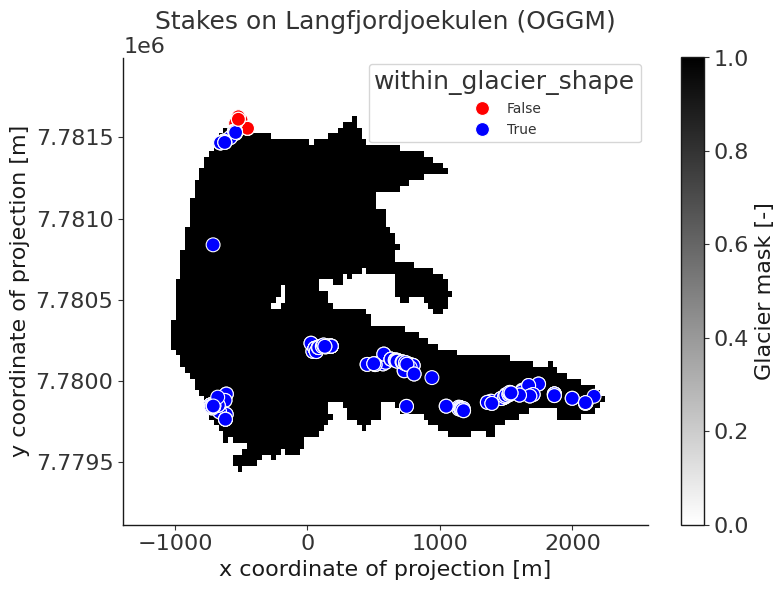

In [14]:
# Example:
glacierName = 'Langfjordjoekulen'
# stakes
df_stakes_topo_1 = df_stakes_topo.copy()
df_stakes_topo_1 = df_stakes_topo_1[(df_stakes_topo_1['GLACIER'] == glacierName)]
RGIId = df_stakes_topo_1['RGIId'].unique()[0]
print(RGIId)
# open OGGM xr for glacier
# Get oggm data for that RGI grid
ds_oggm = xr.open_dataset(f'{cfg.dataPath + path_OGGM_xrgrids}/{RGIId}.zarr')

# Define the coordinate transformation
transf = pyproj.Transformer.from_proj(
    pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
    pyproj.CRS.from_user_input(ds_oggm.pyproj_srs),  # Output CRS from dataset
    always_xy=True)

# Transform all coordinates in the group
lon, lat = df_stakes_topo_1["POINT_LON"].values, df_stakes_topo_1["POINT_LAT"].values
x_stake, y_stake = transf.transform(lon, lat)
df_stakes_topo_1['x'] = x_stake
df_stakes_topo_1['y'] = y_stake

# plot stakes
plt.figure(figsize=(8, 6))
ds_oggm.glacier_mask.plot(cmap='binary')
sns.scatterplot(df_stakes_topo_1,
                x='x',
                y='y',
                hue='within_glacier_shape',
                palette=['r', 'b'])
plt.title(f'Stakes on {glacierName} (OGGM)')
plt.tight_layout()

###### Only keep glaciers within RGIId shape and drop rows with NaN values anywhere

In [15]:
# restrict to within glacier shape
df_stakes_topo = df_stakes_topo[df_stakes_topo['within_glacier_shape'] == True]
df_stakes_topo = df_stakes_topo.drop(columns=['within_glacier_shape'])

# Drop rows with NaN in consensus_ice_thickness
df_stakes_topo = df_stakes_topo.dropna(subset=['consensus_ice_thickness'])

print('Number of winter and annual samples:', len(df_stakes_topo))
print('Number of annual samples:',
      len(df_stakes_topo[df_stakes_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_stakes_topo[df_stakes_topo.PERIOD == 'winter']))

# Unique glaciers, sorted
glacier_list = sorted(df_stakes_topo.GLACIER.unique())
print(f"Number of glaciers: {len(glacier_list)}")
print(f"Glaciers: {glacier_list}")


Number of winter and annual samples: 6275
Number of annual samples: 3184
Number of winter samples: 3091
Number of glaciers: 32
Glaciers: ['Aalfotbreen', 'Austdalsbreen', 'Austre Memurubreen', 'Blaaisen', 'Blabreen', 'Blomstoelskardsbreen', 'Bondhusbrea', 'Breidablikkbrea', 'Cainhavarre', 'Engabreen', 'Graafjellsbrea', 'Graasubreen', 'Hansebreen', 'Harbardsbreen', 'Hellstugubreen', 'Hoegtuvbreen', 'Juvfonne', 'Langfjordjoekulen', 'Moesevassbrea', 'Nigardsbreen', 'Rembesdalskaaka', 'Ruklebreen', 'Rundvassbreen', 'Storglombreen N', 'Storsteinsfjellbreen', 'Svartisheibreen', 'Svelgjabreen', 'Trollbergdalsbreen', 'Tunsbergdalsbreen', 'Vesledalsbreen', 'Vestre Memurubreen', 'Vetlefjordbreen']


In [16]:
# Check for NaN
display(df_stakes_topo[df_stakes_topo.isna().any(axis=1)])

,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,POINT_ID,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness


In [17]:
# Save df to folder
df_stakes_topo.to_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm.csv', index=False)
display(df_stakes_topo.head(2))


,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,POINT_ID,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness
0,70.12589,21.77702,471,20120925,20131107,-4.92,annual,RGI60-08.01258,2013,Langfjordjoekulen,,Langfjordjoekulen_2013_annual_70.12589_21.7770...,36.073272,15.972541,425.458893,-3.314563,96.980293
1,70.12521,21.76711,540,20120925,20131107,-3.83,annual,RGI60-08.01258,2013,Langfjordjoekulen,,Langfjordjoekulen_2013_annual_70.12521_21.7671...,65.884818,12.091276,523.195557,-2.681456,100.969521
